# Ember

A multimodal sentiment analysis model able to fuse transcription semantics and prosody to detect nuanced emotions in speech.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset, Audio, Dataset

from torchinfo import summary

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 600)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
device

'cuda:0'

In [3]:
rec_path = 'inputs/rec_pre.mp3'
seg_path = 'outputs/transcript.parquet'

## Transcription

In [4]:
model_id = "openai/whisper-large-v3"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id,
    torch_dtype=torch_dtype,
    low_cpu_mem_usage=True,
    use_safetensors=True
)
model.to(device)

model.generation_config.cache_implementation = 'static'
model.forward = torch.compile(model.forward, mode='reduce-overhead', fullgraph=True)

processor = AutoProcessor.from_pretrained(model_id)

In [5]:
summary(model)

Layer (type:depth-idx)                             Param #
WhisperForConditionalGeneration                    --
├─WhisperModel: 1-1                                --
│    └─WhisperEncoder: 2-1                         --
│    │    └─Conv1d: 3-1                            492,800
│    │    └─Conv1d: 3-2                            4,916,480
│    │    └─Embedding: 3-3                         (1,920,000)
│    │    └─ModuleList: 3-4                        629,637,120
│    │    └─LayerNorm: 3-5                         2,560
│    └─WhisperDecoder: 2-2                         --
│    │    └─Embedding: 3-6                         66,388,480
│    │    └─WhisperPositionalEmbedding: 3-7        573,440
│    │    └─ModuleList: 3-8                        839,557,120
│    │    └─LayerNorm: 3-9                         2,560
├─Linear: 1-2                                      66,388,480
Total params: 1,609,879,040
Trainable params: 1,607,959,040
Non-trainable params: 1,920,000

In [6]:
dataset = Dataset.from_dict({'audio': [rec_path]})
dataset = dataset.cast_column('audio', Audio(processor.feature_extractor.sampling_rate))
audio = dataset[0]['audio']

In [7]:
inputs = processor(
    audio['array'],
    sampling_rate=audio['sampling_rate'],
    return_tensors='pt',
    truncation=False,
    padding='longest',
    return_attention_mask=True,
    predict_timestamps=True
)
inputs = inputs.to(device, dtype=torch_dtype)

In [22]:
prompt_ids = torch.tensor(processor.get_prompt_ids('onto' 'promortalist' 'promortalism' 'Inmendham'), device=device)

gen_kwargs = {
    'language': 'en',
    'return_timestamps': True,
    'return_segments': True,
    'prompt_ids': prompt_ids,
    #'return_token_timestamps': True
}

torch.compiler.cudagraph_mark_step_begin()

pred_ids = model.generate(**inputs, **gen_kwargs)

In [23]:
pred_text = processor.batch_decode(pred_ids['sequences'], skip_special_tokens=True)[0].strip()
pred_text

"Okay, so I figured I would just make a recording explaining why I've decided to bomb an IVF building or clinic. Basically, it just comes down to I'm angry that I exist. And that's, you know, nobody got my consent to bring me here. And I know what you're going to say. How could we have got your consent because you didn't exist, blah, blah, blah. Exactly the point. There's no way you can get consent to bring someone here. So don't fucking do it. Right. um and if you're going to try to say something really fucking retarded like well since you don't exist you don't have a consent status and therefore we don't have to get consent this really isn't any different from saying oh well the girl's unconscious so i can't get you know i can't get her consent to have sex with her so therefore it's okay because i can't there's no way to even ask for the consent right um so i mean if you actually think that's a good argument against what i've said right you're absolutely retarded your brain you're it

In [33]:
segments = pd.DataFrame.from_records(pred_ids['segments'][0], coerce_float=True)[['start', 'end', 'tokens']]
segments['text'] = segments['tokens'].map(lambda x: processor.decode(x, skip_special_tokens=True))
segments['duration'] = segments.end - segments.start
segments = segments[['start', 'end', 'duration', 'text']]
display(segments)

,start,end,duration,text
0,0.00,7.72,7.72,"Okay, so I figured I would just make a recording explaining why I've decided to bomb an IVF building or clinic."
1,10.06,14.16,4.10,"Basically, it just comes down to I'm angry that I exist."
2,15.20,18.78,3.58,"And that's, you know, nobody got my consent to bring me here."
3,18.96,20.12,1.16,And I know what you're going to say.
4,20.34,23.60,3.26,"How could we have got your consent because you didn't exist, blah, blah, blah."
5,24.42,25.24,0.82,Exactly the point.
6,25.88,27.92,2.04,There's no way you can get consent to bring someone here.
7,28.00,29.02,1.02,So don't fucking do it.
8,29.12,29.34,0.22,Right.
9,29.34,33.38,4.04,um and if you're going to try to say something really fucking retarded like


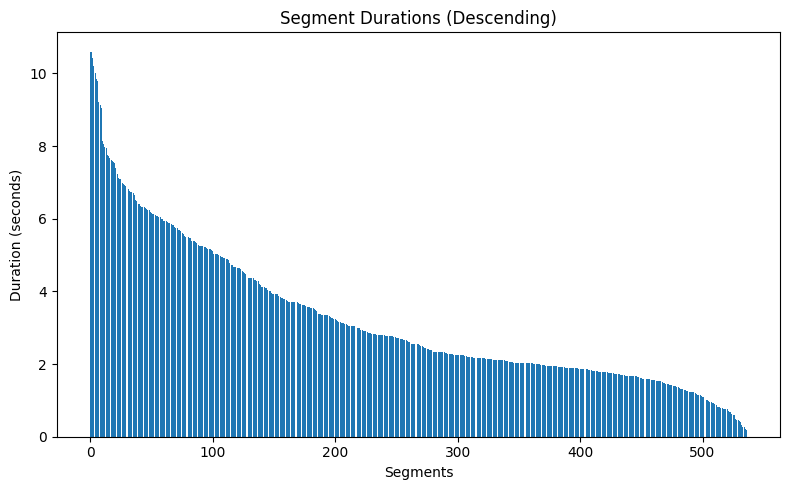

In [34]:
# Plot
durations = sorted(segments.duration, reverse=True)
plt.figure(figsize=(8, 5))
plt.bar(range(len(durations)), durations)
plt.xlabel("Segments")
plt.ylabel("Duration (seconds)")
plt.title("Segment Durations (Descending)")
plt.tight_layout()
plt.show()

In [70]:
def join_segments(durations, threshold=3.0):
    group_id = 0
    total = 0.0
    ids = []
    for dur in durations:
        total += dur
        ids.append(group_id)
        if total > threshold:
            group_id += 1
            total = 0.0
    if durations.iloc[-1] <= threshold:
        ids[-1] = ids[-2]
    return ids

segments.index = join_segments(segments.duration)

agg_segments = (
    segments.groupby(level=0)
            .agg({'start': "first", 'end': "last", 'duration': "sum", 'text': " ".join})
            .reset_index(drop=True)
)
agg_segments

,start,end,duration,text
0,0.00,7.72,7.72,"Okay, so I figured I would just make a recording explaining why I've decided to bomb an IVF building or clinic."
1,10.06,14.16,4.10,"Basically, it just comes down to I'm angry that I exist."
2,15.20,18.78,3.58,"And that's, you know, nobody got my consent to bring me here."
3,18.96,23.60,4.42,"And I know what you're going to say. How could we have got your consent because you didn't exist, blah, blah, blah."
4,24.42,29.02,3.88,Exactly the point. There's no way you can get consent to bring someone here. So don't fucking do it.
5,29.12,33.38,4.26,Right. um and if you're going to try to say something really fucking retarded like
6,33.38,37.38,4.00,well since you don't exist you don't have a consent status and therefore we don't have to
7,37.38,43.62,6.24,get consent this really isn't any different from saying oh well the girl's unconscious so i can't
8,43.62,49.60,5.98,get you know i can't get her consent to have sex with her so therefore it's okay because i can't
9,49.60,54.86,5.26,there's no way to even ask for the consent right um so i mean if you actually think that's a good


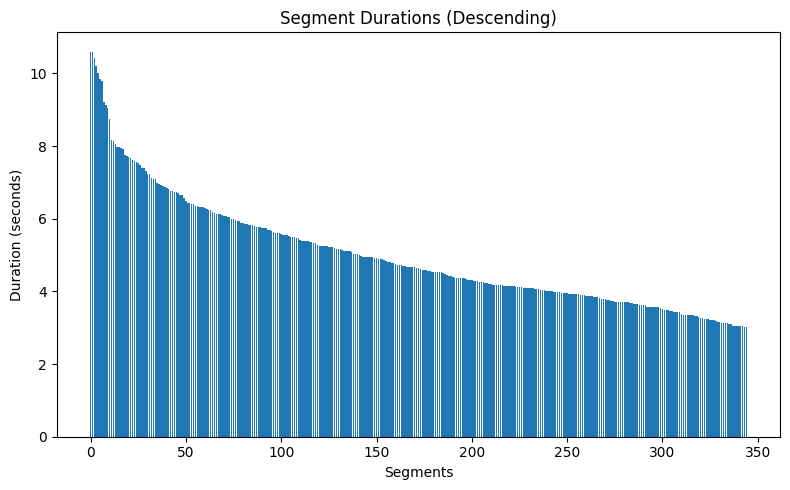

In [71]:
# Plot
durations = sorted(agg_segments.duration, reverse=True)
plt.figure(figsize=(8, 5))
plt.bar(range(len(durations)), durations)
plt.xlabel("Segments")
plt.ylabel("Duration (seconds)")
plt.title("Segment Durations (Descending)")
plt.tight_layout()
plt.show()

In [72]:
agg_segments[['start', 'end', 'text']].to_parquet(seg_path)

In [ ]:
tokenizer = processor.tokenizer

token_ids = pred_ids['sequences'][0].tolist()
timestamps = pred_ids['token_timestamps'][0].tolist()

df = pd.DataFrame(zip(
    tokenizer.get_special_tokens_mask(token_ids),
    tokenizer.batch_decode(token_ids),
    timestamps
), columns=['special', 'text', 'timestamp']
)
df[df['special'] == 0][['text', 'timestamp']]